In [9]:
import imageio
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
import cv2
from tqdm import tqdm
import os
from imgaug import augmenters as iaa

In [22]:
exper_image = cv2.imread(r'D:\NN_projects\CDS_digit_rec\data\0\0_10.jpg')[:, :] / 255

In [3]:
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)),
    iaa.PerspectiveTransform(scale=(0.01, 0.2)),
    # iaa.Affine(
    #     scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
    #     translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    #     rotate=(-25, 25),
    #     # shear=(-8, 8)
    # )
], random_order=True)

In [50]:
def transform_pipeline(image):
    """
    This func is used for image preprocessing before recognition

    Args:
        image (ndarray): given image

    Returns:
        ndarray : image ready for recognition
    """
    if len(image.shape) == 3:
        gray_image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()
    w, h = gray_image.shape
    thresh = cv2.resize(gray_image, (0, 0), fx=28 / h, fy=28 / w, interpolation= cv2.INTER_CUBIC)
    # sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    # thresh = cv2.filter2D(thresh, -1, sharpen_kernel)
    # thresh = cv2.threshold(thresh, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # thresh = cv2.GaussianBlur(thresh, (7,7), 1)
    return thresh

In [51]:
def image_files(input_directory):
    loaded = []
    labels=[]
    
    digit_folders=os.listdir(input_directory)
    print(digit_folders)
    
    for digit in digit_folders:
        path=os.path.join(input_directory, digit)
        flist=os.listdir(path)
        for f in tqdm(flist):
            fpath=os.path.join(path,f) 
            img = cv2.imread(fpath)
            img = (transform_pipeline(img)).astype(float)
            for _ in range(3):
                img1 = seq.augment_image(img)
                labels.append(int(digit))
                loaded.append(np.asarray(img1, dtype = 'float32'))
            loaded.append(np.asarray(img, dtype = 'float32'))
            labels.append(int(digit))
    loaded = np.array(loaded)
    return loaded, np.array(labels, dtype = 'int16')

images, labels = image_files('data')
# images = load_images(filepaths)
images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int16')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


100%|██████████| 25107/25107 [00:14<00:00, 1787.21it/s]


In [207]:
device = 'cuda'

In [206]:
def pytorch_predict(model, test_loader, device):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)
    
    # deactivate autograd engine and reduce memory usage and speed up computations
    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
    y_true = y_true.cpu().numpy()  
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()
    y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    
    return y_true, y_pred, y_pred_prob



In [203]:
# model = torch.jit.load('model_conv1.pt')
images, labels = image_files('data')

images = np.array(images)
labels = np.array(labels, dtype = 'int16')
features_train_val, features_test, target_train_val, target_test = train_test_split(images, labels, test_size=0.2, random_state=42)
features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val, test_size=0.1, random_state=42)
features_test, features_train = features_test / 255, features_train / 255

featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor) 

featuresVal = torch.from_numpy(features_val)
targetsVal = torch.from_numpy(target_val).type(torch.LongTensor)

batch_size = 2048

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)
val = torch.utils.data.TensorDataset(featuresVal,targetsVal)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False, generator=torch.Generator(device='cuda'))
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False, generator=torch.Generator(device='cuda'))
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False, generator=torch.Generator(device='cuda'))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


100%|██████████| 25107/25107 [00:10<00:00, 2405.12it/s]


In [227]:
val = torch.utils.data.TensorDataset(featuresVal.unsqueeze(1),targetsVal)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)

In [204]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.8),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.6),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [ ]:
with torch.device('cuda'):
    model = Classifier()
    # Define our loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimier
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    epochs = 20
    steps = 0
    print_every = 50
    train_losses, test_losses = [], []
    
    for e in tqdm(range(epochs)):
        running_loss = 0
        for images, labels in train_loader:
            images = images.cuda()
            labels = labels.cuda()
            steps += 1
            # Prevent accumulation of gradients
            optimizer.zero_grad()
            # Make predictions
            # print(torch.flatten(images, start_dim=1), labels.shape)
            # print(images.unsqueeze(1).shape)
            log_ps = model(images.unsqueeze(1))
            loss = criterion(log_ps, labels)
        #backprop
            loss.backward()
            optimizer.step()
            # 
            running_loss += loss.item()
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
             
                 # Turn off gradients for validation
                with torch.no_grad():
                    model.eval()
                    for images, labels in test_loader:
                        images = images.cuda()
                        labels = labels.cuda()
                        log_ps = model(images.cuda().unsqueeze(1))
                        test_loss += criterion(log_ps, labels.cuda())
    
                        ps = torch.exp(log_ps)
                        # Get our top predictions
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
                model.train()
        
                train_losses.append(running_loss/len(train_loader))
                test_losses.append(test_loss/len(test_loader))
    
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                      "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                      "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

In [211]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_conv2_no_leaks.pt') # Save

In [ ]:
model = torch.jit.load('model_conv2.pt')
model.eval()

In [208]:
test_losses = [i.cpu() for i in test_losses]

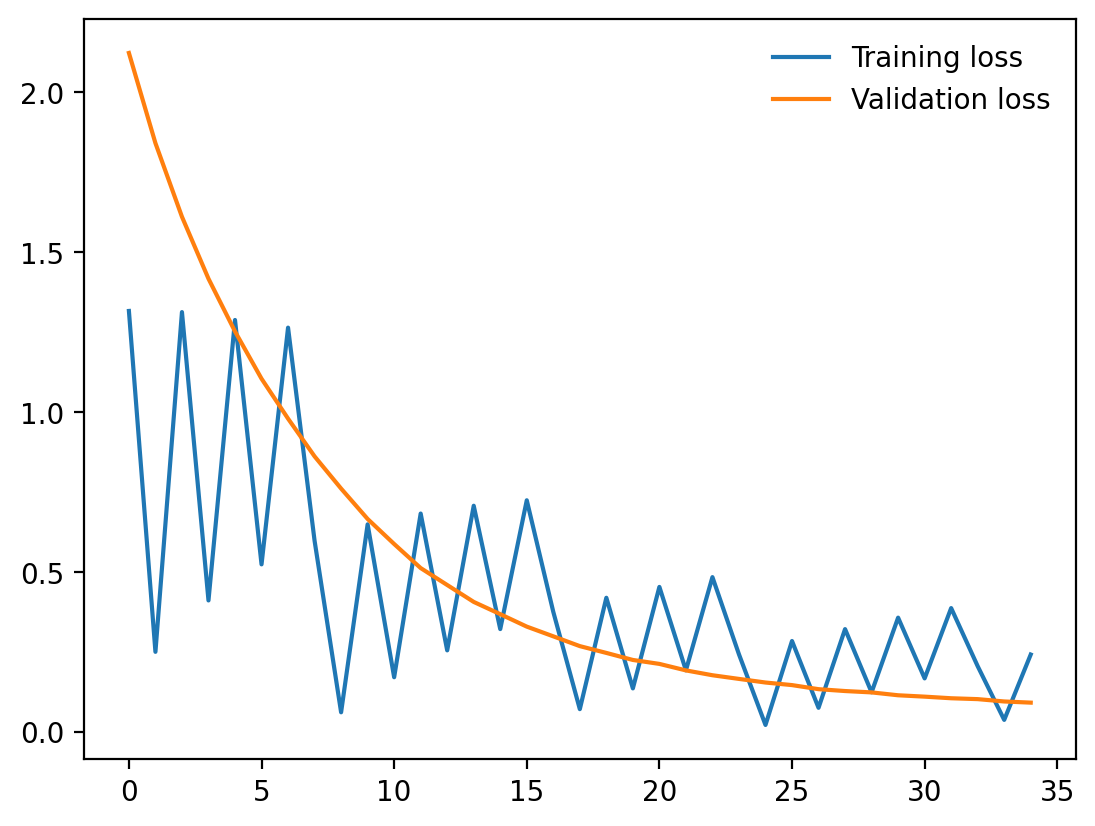

In [209]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [234]:
model1 = torch.jit.load('model_conv2_no_leaks.pt', torch.device('cuda:0'))
# model1.eval()
val_true, val_predicted, _ = pytorch_predict(model1, val_loader, 'cuda:0')


100%|██████████| 10/10 [00:00<00:00, 19.04it/s]


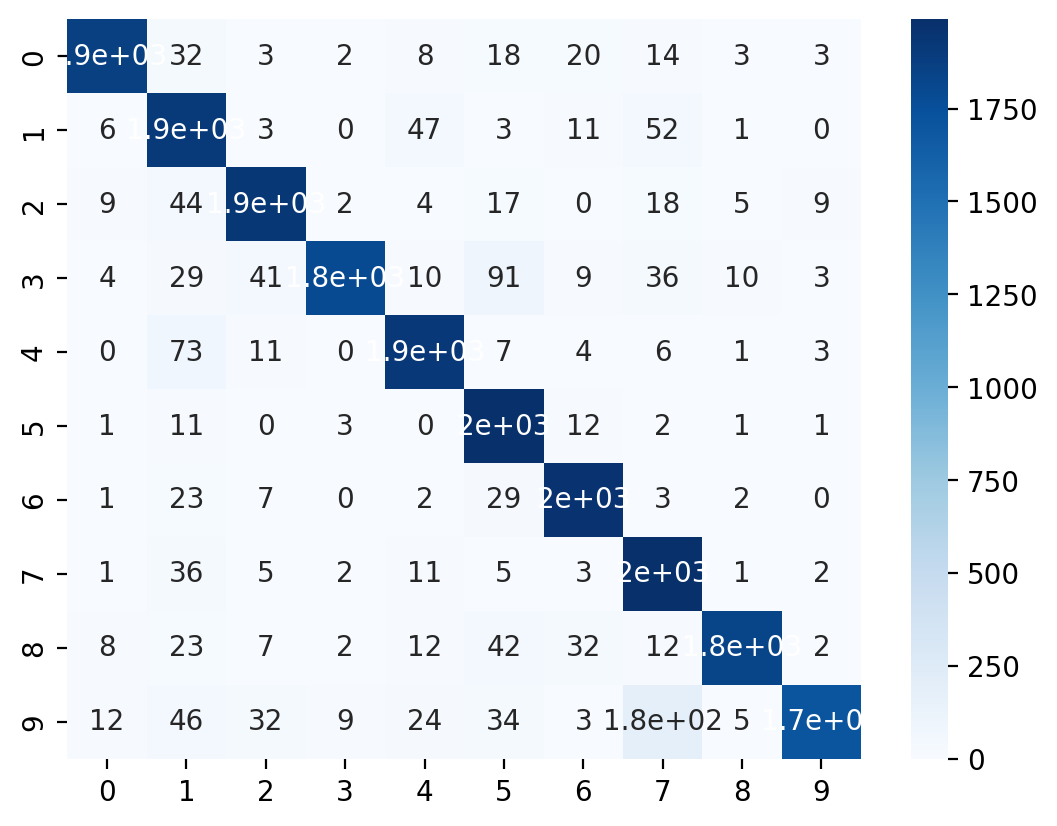

In [235]:
confusion = confusion_matrix(val_true, val_predicted)
import seaborn as sns

ax = sns.heatmap(confusion, annot=True, cmap='Blues')

In [236]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(val_true, val_predicted)
accuracy

0.934450541302091